In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Split data into train, test

In [2]:
from datasets.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
X_train, y_train, X_test, _ = dataset.get_original_train_test_split()

[INFO] Dropped rows with NaN: 478 (kept 522)


e:\github_repositories\COLA\datasets\german_credit.py:88: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[self.target_name]


### 2. Build the preprocessor

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature lists
numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Build the preprocessor — use OrdinalEncoder
cat_pipe = Pipeline(steps=[
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,      # unseen categories are encoded as -1 (usually not present during fit)
        # Optional: if you want to explicitly specify the order (recommended), list from low to high
        # categories=[ ['primary', 'secondary', 'bachelor', 'master', 'phd'], ... ]
    )),
    ('sc', StandardScaler())    # standardize the ordinal-encoded outputs
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', cat_pipe, categorical_features),
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Age', 'Credit amount', 'Duration']),
                                ('cat',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('sc', StandardScaler())]),
                                 ['Sex', 'Job', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

### 3. Train the model (Built-in DNN)

In [4]:
from xai_cola.ce_sparsifier.utils.pytorch_models import DNN, LinearSVM
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Prepare data — input_dim is inferred from the processed data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)
input_dim = X_train_processed.shape[1]  # dynamically obtain feature dimension

X_train = torch.FloatTensor(X_train_processed)               # shape: [n_samples, n_features]
y_train = torch.FloatTensor(y_train.values).unsqueeze(1)     # shape: [n_samples, 1]

# 2. Create model
model1 = DNN(input_dim=input_dim, hidden_dim=30)  # input_dim = number of features
# model2 = LinearSVM(input_dim=input_dim)

# 3. Train
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(100):
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


c:\Users\ZhuLi\miniconda3\envs\test-py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Pick instances(whose predictions are 1)

In [5]:
import pandas as pd

# === Config ===
TARGET_COLUMN_NAME = "Risk"   # name of the prediction column
N = 10                        # number of rows to sample; set to None to return all
RANDOM_STATE = 42

# 1) Predict
X_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
X_transformed = preprocessor.transform(X_df)
preds = pd.Series(model1.predict(X_transformed), index=X_df.index, name=TARGET_COLUMN_NAME).astype(int)


# 2) Overwrite instead of append (avoid duplicate columns)
X_df = X_df.drop(columns=[TARGET_COLUMN_NAME], errors="ignore")
X_df[TARGET_COLUMN_NAME] = preds.values
X_test = X_df  # overwrite the variable

# 3) Select rows predicted as 1 and optionally sample
df = X_test.loc[X_test[TARGET_COLUMN_NAME] == 1]
if N is not None and len(df) > N:
    df = df.sample(n=N, random_state=RANDOM_STATE)

# Optional: inspect
# display(X_test.head())
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25,male,unskilled and resident,own,little,moderate,685,12,car,1
253,42,female,highly skilled,free,little,moderate,8318,27,business,1
238,34,female,highly skilled,rent,little,moderate,3017,12,furniture/equipment,1
489,42,male,skilled,free,little,moderate,6288,60,education,1
256,32,male,unskilled and resident,own,little,moderate,1301,18,radio/TV,1


---------------------------

### **1**. Initialize data interface (COLAData)

In [6]:
from xai_cola.ce_sparsifier.data import COLAData

numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
data = COLAData(
    factual_data=df, 
    label_column='Risk',
    numerical_features=numerical_features,
    transform_method=preprocessor,
)
print(data)

COLAData(factual: 10 rows, features: 9, label: Risk, no counterfactual)


### **2**. Initialize model interface (Model)

In [7]:
from xai_cola.ce_sparsifier.models import Model

ml_model = Model(model=model1, backend="pytorch")

### **3.** Choose the counterfactual generator & generate counterfactuals

In [9]:
from xai_cola.ce_generator import DiCE, DisCount

explainer = DisCount(ml_model=ml_model)
factual, counterfactual = explainer.generate_counterfactuals(
    data=data,
    factual_class=1,  # class label of the factual instances (target column)
    # explain_columns=[
    #     'Housing','Saving accounts','Checking account',
    #     'Credit amount','Duration'
    # ],
    max_iter=200,     # Max iteration steps (can add early stopping)
    silent=True,     # whether to print logs during optimization
)
display(counterfactual)


# Add counterfactual data to COLAData object first
data.add_counterfactuals(counterfactual, with_target_column=True)
data.summary()

INFO:root:Optimization started
100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25,male,unskilled and resident,own,little,moderate,726,12,car,1
253,42,female,highly skilled,free,little,moderate,7638,24,business,0
238,35,female,highly skilled,rent,little,moderate,3359,9,furniture/equipment,0
489,43,male,skilled,free,little,moderate,5752,59,education,0
256,30,male,unskilled and resident,own,little,moderate,1704,16,radio/TV,0
267,19,male,skilled,rent,little,moderate,999,8,radio/TV,0
359,64,male,unskilled and resident,rent,little,little,2625,19,radio/TV,0
357,41,male,skilled,own,little,rich,3882,34,furniture/equipment,0
45,23,male,skilled,own,little,moderate,3766,27,furniture/equipment,0
323,22,female,skilled,own,moderate,little,725,12,domestic appliances,1


{'factual_samples': 10,
 'feature_count': 9,
 'label_column': 'Risk',
 'all_columns': ['Age',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Credit amount',
  'Duration',
  'Purpose',
  'Risk'],
 'has_counterfactual': True,
 'has_transform_method': True,
 'has_transformed_data': True,
 'counterfactual_samples': 10,
 'transformed_feature_columns': ['Age',
  'Credit amount',
  'Duration',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Purpose'],
 'has_transformed_counterfactual': True}

### **4.** Initialize COLA & set policy

In [10]:
from xai_cola.ce_sparsifier import COLA

# Initialize COLA - it will automatically extract factual and counterfactual from data
sparsifier = COLA(
    data=data,
    ml_model=ml_model
)

sparsifier.set_policy(
    matcher="nn", # optimal transport matcher
    attributor="pshap", # SHAP attributor
    random_state=1 # Set random seed for reproducibility
)

Using transformed data from COLAData (transform_method: ColumnTransformer)
Policy set: pshap with Nearest Neighbor Matching.


### **5.** Refine counterfactuals with COLA

In [11]:
# Query minimum actions
limited_actions = sparsifier.query_minimum_actions()

The minimum number of actions is 12


In [12]:
# Get (refined counterfactuals) with limited actions
refined_cf_df = sparsifier.get_refined_counterfactual(limited_actions=limited_actions)
display(refined_cf_df)

# Get (factual, counterfactual, refined counterfactuals) with limited actions
# factual_df, counterfactual_df, refined_cf_df = sparsifier.get_all_results(
#     limited_actions=limited_actions,
#     # features_to_vary=['Saving accounts','Checking account','Credit amount','Duration','Purpose']
# )
# display(counterfactual_df,refined_cf_df)

  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 2.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([0.1063163 , 0.14436176])
  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([0.03829617, 0.07207466, 0.30602199])
  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([0.00405514, 0.02278915, 0.00260195])
  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = array([0.24743975, 0.17255463, 0.24754078])
  0%|          | 0/1 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:np.sum(w_aug) = 3.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:sh


[DEBUG] Predictions on transformed factual: [1 1 1 1 1 1 1 1 1 1]

[DEBUG] Predictions on transformed counterfactual: [1 1 0 1 0 0 0 0 0 1]
[DEBUG] Predictions on x_action_constrained (before inverse_transform): [1 1 0 1 0 0 0 0 0 1]
[DEBUG] Predictions on corresponding_counterfactual (q): [1 1 0 1 0 0 0 0 0 1]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25.0,male,unskilled and resident,own,little,moderate,685.0,12.0,car,1
253,42.0,female,highly skilled,free,little,moderate,7638.0,24.0,business,1
238,34.0,female,highly skilled,rent,little,moderate,3017.0,9.0,furniture/equipment,0
489,42.0,male,skilled,free,little,moderate,6288.0,60.0,education,1
256,30.0,male,unskilled and resident,own,little,moderate,1301.0,16.0,radio/TV,0
267,19.0,male,skilled,rent,little,moderate,585.0,8.0,radio/TV,0
359,64.0,male,unskilled and resident,rent,little,little,2384.0,19.0,radio/TV,0
357,41.0,male,skilled,own,little,rich,3017.0,34.0,furniture/equipment,0
45,22.0,male,skilled,own,little,moderate,3832.0,27.0,furniture/equipment,0
323,22.0,female,skilled,own,moderate,little,741.0,12.0,domestic appliances,1


#### **6.** Visualization

##### 6.1 Highlight the changes between factual and counterfactual

In [13]:
factual, ce, refine_ce = sparsifier.highlight_changes_comparison()
display(factual, ce, refine_ce) # display the highlighted dataframes
# refine_ce.to_html('comparison.html')  # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25,male,unskilled and resident,own,little,moderate,685,12,car,1
253,42,female,highly skilled,free,little,moderate,8318,27,business,1
238,34,female,highly skilled,rent,little,moderate,3017,12,furniture/equipment,1
489,42,male,skilled,free,little,moderate,6288,60,education,1
256,32,male,unskilled and resident,own,little,moderate,1301,18,radio/TV,1
267,20,male,skilled,rent,little,moderate,585,12,radio/TV,1
359,64,male,unskilled and resident,rent,little,little,2384,24,radio/TV,1
357,47,male,skilled,own,little,rich,3017,30,radio/TV,1
45,22,male,skilled,own,little,moderate,3832,30,furniture/equipment,1
323,22,female,skilled,own,moderate,little,741,12,domestic appliances,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25.000000,male,unskilled and resident,own,little,moderate,685 -> 726.0,12.000000,car,1
253,42.000000,female,highly skilled,free,little,moderate,8318 -> 7638.0,27 -> 24.0,business,1
238,34 -> 35.0,female,highly skilled,rent,little,moderate,3017 -> 3359.0,12 -> 9.0,furniture/equipment,1 -> 0
489,42 -> 43.0,male,skilled,free,little,moderate,6288 -> 5752.0,60 -> 59.0,education,1
256,32 -> 30.0,male,unskilled and resident,own,little,moderate,1301 -> 1703.9999999999998,18 -> 16.0,radio/TV,1 -> 0
267,20 -> 19.0,male,skilled,rent,little,moderate,585 -> 999.0,12 -> 8.0,radio/TV,1 -> 0
359,64.000000,male,unskilled and resident,rent,little,little,2384 -> 2625.0,24 -> 19.0,radio/TV,1 -> 0
357,47 -> 41.0,male,skilled,own,little,rich,3017 -> 3882.0,30 -> 34.0,radio/TV -> furniture/equipment,1 -> 0
45,22 -> 23.0,male,skilled,own,little,moderate,3832 -> 3766.0,30 -> 27.0,furniture/equipment,1 -> 0
323,22.000000,female,skilled,own,moderate,little,741 -> 725.0,12.000000,domestic appliances,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25.000000,male,unskilled and resident,own,little,moderate,685.000000,12.000000,car,1
253,42.000000,female,highly skilled,free,little,moderate,8318 -> 7638.0,27 -> 24.0,business,1
238,34.000000,female,highly skilled,rent,little,moderate,3017.000000,12 -> 9.0,furniture/equipment,1 -> 0
489,42.000000,male,skilled,free,little,moderate,6288.000000,60.000000,education,1
256,32 -> 30.0,male,unskilled and resident,own,little,moderate,1301.000000,18 -> 16.0,radio/TV,1 -> 0
267,20 -> 19.0,male,skilled,rent,little,moderate,585.000000,12 -> 8.0,radio/TV,1 -> 0
359,64.000000,male,unskilled and resident,rent,little,little,2384.000000,24 -> 19.0,radio/TV,1 -> 0
357,47 -> 41.0,male,skilled,own,little,rich,3017.000000,30 -> 34.0,radio/TV -> furniture/equipment,1 -> 0
45,22.000000,male,skilled,own,little,moderate,3832.000000,30 -> 27.0,furniture/equipment,1 -> 0
323,22.000000,female,skilled,own,moderate,little,741.000000,12.000000,domestic appliances,1


##### 6.2 Highlight the changed positions in counterfactuals and refined counterfactuals

In [14]:
factual_df, ce_style, ace_style = sparsifier.highlight_changes_final()
display(ce_style, ace_style)  # display the highlighted dataframes
# ce_style.to_html('final.html') # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25.000000,male,unskilled and resident,own,little,moderate,726.000000,12.000000,car,1
253,42.000000,female,highly skilled,free,little,moderate,7638.000000,24.000000,business,1
238,35.000000,female,highly skilled,rent,little,moderate,3359.000000,9.000000,furniture/equipment,0
489,43.000000,male,skilled,free,little,moderate,5752.000000,59.000000,education,1
256,30.000000,male,unskilled and resident,own,little,moderate,1704.000000,16.000000,radio/TV,0
267,19.000000,male,skilled,rent,little,moderate,999.000000,8.000000,radio/TV,0
359,64.000000,male,unskilled and resident,rent,little,little,2625.000000,19.000000,radio/TV,0
357,41.000000,male,skilled,own,little,rich,3882.000000,34.000000,furniture/equipment,0
45,23.000000,male,skilled,own,little,moderate,3766.000000,27.000000,furniture/equipment,0
323,22.000000,female,skilled,own,moderate,little,725.000000,12.000000,domestic appliances,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
164,25.000000,male,unskilled and resident,own,little,moderate,685.000000,12.000000,car,1
253,42.000000,female,highly skilled,free,little,moderate,7638.000000,24.000000,business,1
238,34.000000,female,highly skilled,rent,little,moderate,3017.000000,9.000000,furniture/equipment,0
489,42.000000,male,skilled,free,little,moderate,6288.000000,60.000000,education,1
256,30.000000,male,unskilled and resident,own,little,moderate,1301.000000,16.000000,radio/TV,0
267,19.000000,male,skilled,rent,little,moderate,585.000000,8.000000,radio/TV,0
359,64.000000,male,unskilled and resident,rent,little,little,2384.000000,19.000000,radio/TV,0
357,41.000000,male,skilled,own,little,rich,3017.000000,34.000000,furniture/equipment,0
45,22.000000,male,skilled,own,little,moderate,3832.000000,27.000000,furniture/equipment,0
323,22.000000,female,skilled,own,moderate,little,741.000000,12.000000,domestic appliances,1


##### 6.3 Heatmap of Changes: Factuals vs. Counterfactuals / Refined Counterfactuals

In [15]:
sparsifier.heatmap_binary(save_path='./results', save_mode='combined',show_axis_labels=False)


Binary changes from factual to counterfactual:
Binary changes from factual to action-limited counterfactual:
✅ Combined heatmap saved to: ./results\combined_heatmap.png


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.4 Heatmap of Change Direction(increase or decrease): Factuals vs. Counterfactuals / Refined Counterfactuals

In [16]:
sparsifier.heatmap_direction(save_path='./results', save_mode='combined',show_axis_labels=False)

Directional changes from factual to counterfactual:
Directional changes from factual to action-limited counterfactual:
✅ Combined directional heatmap saved to: ./results\combined_direction_heatmap.png


e:\github_repositories\COLA\xai_cola\ce_sparsifier\visualization\heatmap_direction.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.5 Actions Required to Flip the Target per Instance: Refined Counterfactuals vs. Original Counterfactuals

✅ Stacked bar chart saved to: ./results\stacked_bar_chart.png


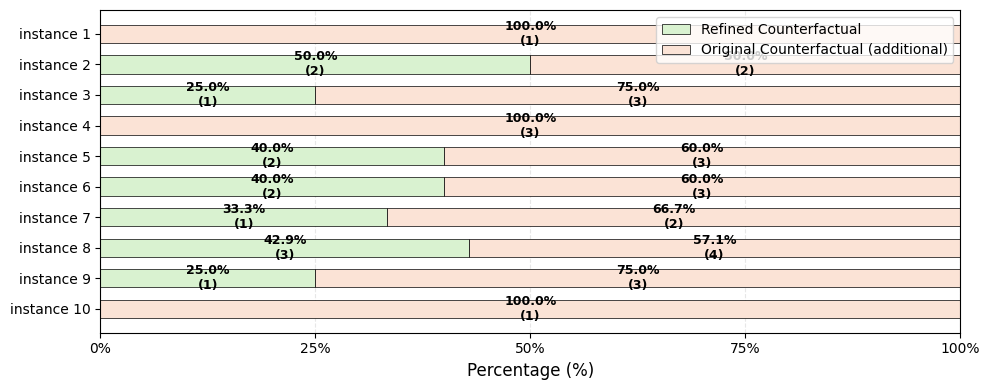

In [17]:
fig = sparsifier.stacked_bar_chart(save_path='./results')

##### 6.6 Diversity results via exhaustive search on refined counterfactuals

In [18]:
factual_df, diversity_styles = sparsifier.diversity()
for i, style in enumerate(diversity_styles):
    print(f"Instance {i+1} diversity:")
    display(style)

Instance 1 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,25.000000,male,unskilled and resident,own,little,moderate,685.000000,12.000000,car,1


Instance 2 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,42.000000,female,highly skilled,free,little,moderate,7638.000000,24.000000,business,1
1,42.000000,female,highly skilled,free,little,moderate,7638.000000,27.000000,business,1
2,42.000000,female,highly skilled,free,little,moderate,8318.000000,24.000000,business,1


Instance 3 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,34.000000,female,highly skilled,rent,little,moderate,3017.000000,9.000000,furniture/equipment,0


Instance 4 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,42.000000,male,skilled,free,little,moderate,6288.000000,60.000000,education,1


Instance 5 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,30.000000,male,unskilled and resident,own,little,moderate,1301.000000,16.000000,radio/TV,0


Instance 6 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,19.000000,male,skilled,rent,little,moderate,585.000000,8.000000,radio/TV,0
1,20.000000,male,skilled,rent,little,moderate,585.000000,8.000000,radio/TV,0


Instance 7 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,64.000000,male,unskilled and resident,rent,little,little,2384.000000,19.000000,radio/TV,0


Instance 8 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,41.000000,male,skilled,own,little,rich,3017.000000,34.000000,furniture/equipment,0
1,41.000000,male,skilled,own,little,rich,3017.000000,34.000000,radio/TV,0
2,41.000000,male,skilled,own,little,rich,3017.000000,30.000000,furniture/equipment,0
3,47.000000,male,skilled,own,little,rich,3017.000000,34.000000,furniture/equipment,0


Instance 9 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22.000000,male,skilled,own,little,moderate,3832.000000,27.000000,furniture/equipment,0


Instance 10 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22.000000,female,skilled,own,moderate,little,741.000000,12.000000,domestic appliances,1
